In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

torch.cuda.set_device(3)

In [74]:
nb_name = 'toy_model'
data_pth = Path('./data/processed_data/')
model_path = Path('/home/rusl/Documents/salk-practicum/lab/judge/')

## Data loading

In [89]:
def get_src(data_pth, stride=3):

    def map_to_target(x, return_fn=True):
        s = str(x)
        i1 = s.index('page')
        i2 = s.index('.tif')
        fi = int(s[i1+4:i2])
        if return_fn:
            return Path(f'{s[:i1]}page{fi+stride}.tif')
        return fi

    print(data_pth)
    src = (ImageImageList
            .from_folder(data_pth)
            .filter_by_func(lambda fname: map_to_target(fname, return_fn=False)<=49-stride)
            .split_subsets(train_size=0.95, valid_size=0.05)
            .label_from_func(map_to_target))
    return src

In [87]:
def get_data(data_pth, bs, num_workers=4, size=256):
    src = get_src(data_pth)
    tfms = [crop(size=size, row_pct=0.5, col_pct=0.5), 
            crop(size=size, row_pct=0.5, col_pct=0.5)]
    data = (src
            .transform(tfms)
            .transform_y(tfms)
            .databunch(bs=bs, num_workers=num_workers)
            .normalize(imagenet_stats, do_y=True))
#     data.c = 3
    return data

In [90]:
db = get_data(data_pth, bs=3, size=1024)

data/processed_data


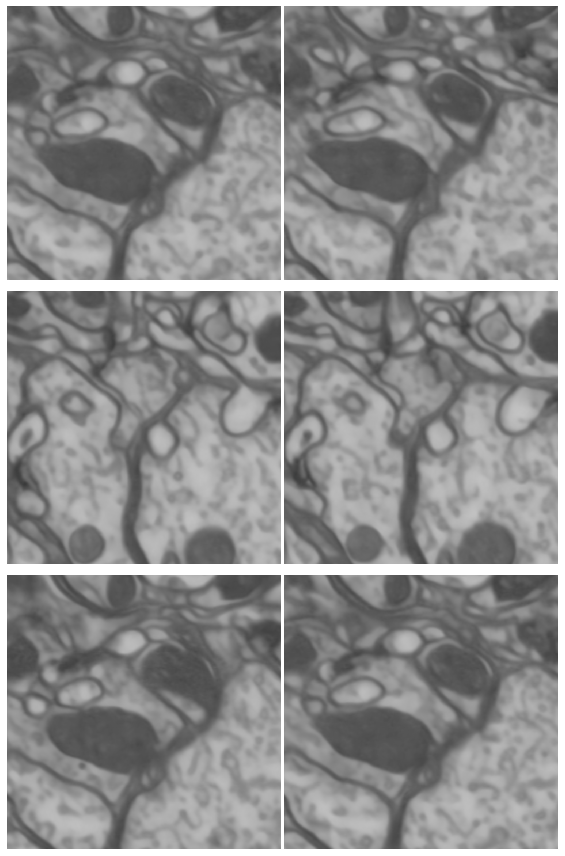

In [91]:
db.show_batch()

## Model

In [7]:
import sys
sys.path.append('/home/rusl/Documents/salk-practicum')
from model.metrics import ssim, psnr

In [92]:
arch = models.resnet34
wd = 1e-3
superres_metrics = [F.mse_loss, ssim, psnr]
learn = unet_learner(db, arch, 
                     wd=wd, 
                     #loss_func=feat_loss,
                     loss_func=F.mse_loss,
                     metrics=F.mse_loss, 
                     #callback_fns=LossMetrics, 
                     blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

41340

In [93]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


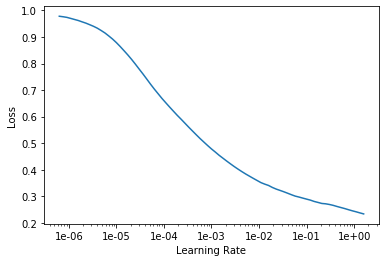

In [94]:
learn.recorder.plot()

In [106]:
lr = 1e-4

In [104]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9, cycle_len=10):
    learn.fit_one_cycle(cycle_len, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=2, imgsize=5)

In [95]:
learn.data

ImageDataBunch;

Train: LabelList (44 items)
x: ImageImageList
Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024)
y: ImageList
Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024)
Path: data/processed_data;

Valid: LabelList (2 items)
x: ImageImageList
Image (3, 1024, 1024),Image (3, 1024, 1024)
y: ImageList
Image (3, 1024, 1024),Image (3, 1024, 1024)
Path: data/processed_data;

Test: None

epoch,train_loss,valid_loss,mse_loss,time
0,0.070343,0.060355,0.060355,00:23
1,0.070492,0.060425,0.060425,00:23
2,0.070012,0.060459,0.060459,00:23


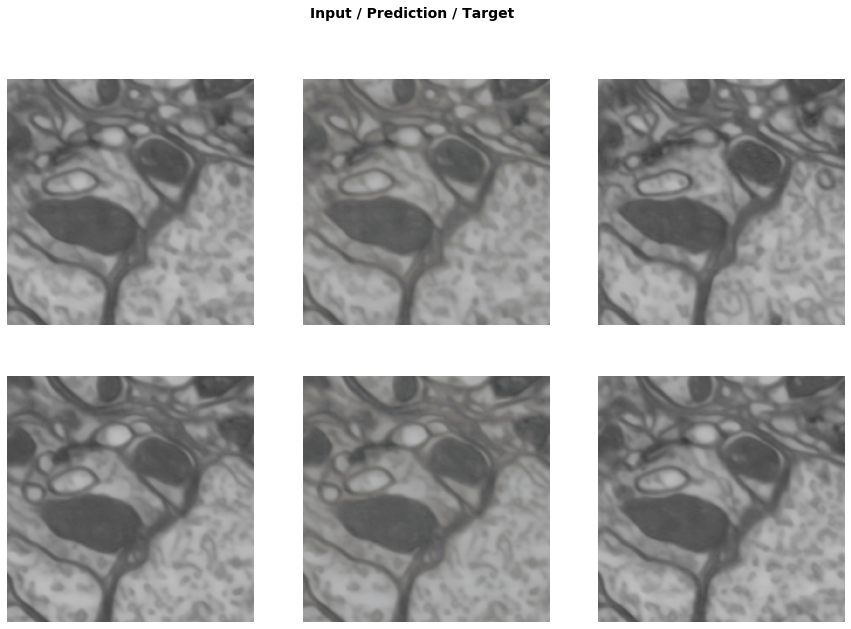

In [107]:
do_fit(f'{nb_name}', lr, cycle_len=3)